https://towardsdatascience.com/time-series-generation-with-vae-lstm-5a6426365a1c

The usage of deep learning models for instance generation is becoming popular over time. These kinds of models are known as generative algorithms and are used in various fields to generate new and unseen samples after studying a population of reference. The most famous adoption of these techniques is well documented in the computer vision domain, where various applications can generate images that don’t exist before.

The utility of the generative models is variegated and domain related. They can be useful to create new instances in a fast way where the manual creation of the same is more expensive or also not possible. They can simulate uncover situations that till that moment are not documented or missed. They can be used to generate different copies that vary from the original one of a certain degree of noise to have enough samples that replicate rare events.

In this post, we present an application of VAE in a time series task. More precisely, we try to use a Variational AutoEncoder structure to fill some time series sequences that can be characterized by the presence of missing data in a real scenario. In the second stage, we also inspect the results produced by our trained VAE to investigate the possibility to produce augmented time-series samples.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
### READ DATA ###

df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz')
df['date_time'] = pd.to_datetime(df['date_time'])
df.drop_duplicates('date_time', inplace=True)
df.set_index('date_time', inplace=True)

print(df.shape)
df.head()

(40575, 8)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [3]:
### INSERT MISSING DATES ###

df = df.reindex(pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H'))

df.shape

(52551, 8)

Text(0, 0.5, 'traffic_volume')

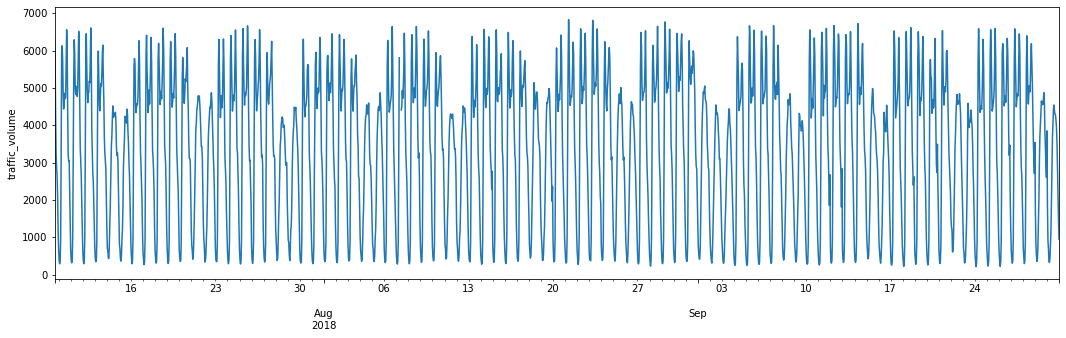

In [4]:
### PLOT TRAFFIC SAMPLE ###

df.traffic_volume.tail(2000).plot(figsize=(18,5))
plt.ylabel('traffic_volume')

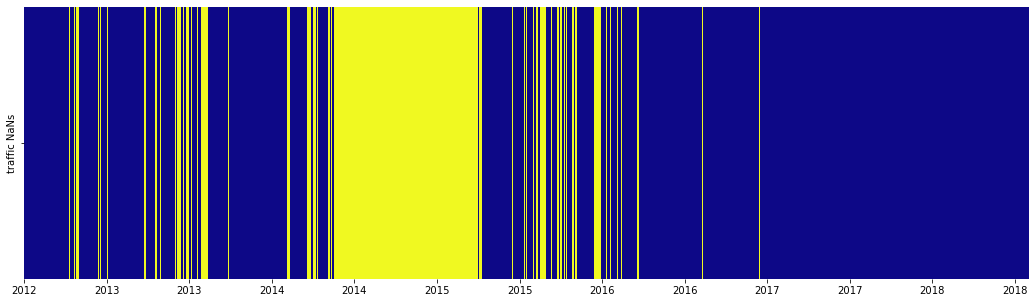

In [5]:
### PLOT MISSING VALUES OVER TIME ###

plt.figure(figsize=(18,5))
sns.heatmap(df[['traffic_volume']].isna().T, cbar=False, cmap='plasma', 
            xticklabels=False, yticklabels=['traffic NaNs'])
plt.xticks(range(0,len(df), 24*180), list(df.index.year[::24*180]))
np.set_printoptions(False)

Since the full history of traffic at our disposal is considerable but with some missing intervals, we decide to focus on the last 3 years of data. This is because the mentioned period seems to be consistent enough due to the rare presence of missing pieces that, in case, can be filled with simple interpolations to have a complete and valuable data source to develop our approach.

In [6]:
### FILL MISSING VALUES ###

df = df[df.index.year.isin([2016,2017,2018])].copy()

df = pd.concat([df.select_dtypes(include=['object']).fillna(method='backfill'),
                df.select_dtypes(include=['float']).interpolate()], axis=1)

df.shape

(24096, 8)

Text(0.5, 0, 'month')

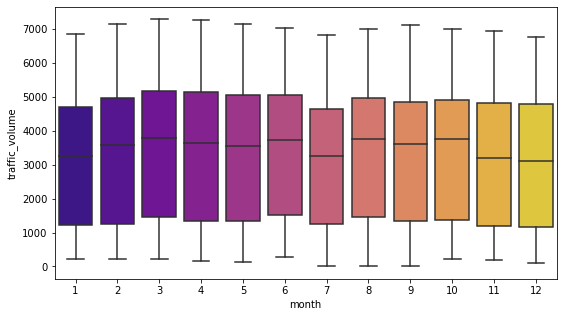

In [7]:
### PLOT TRAFFIC DISTRIBUTION IN EACH MONTH ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.month, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('month')

Text(0.5, 0, 'weekday')

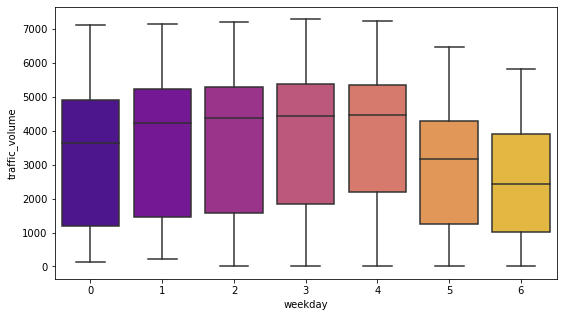

In [8]:
### PLOT TRAFFIC DISTRIBUTION IN EACH WEEKDAY ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.weekday, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('weekday')

Text(0.5, 0, 'hour')

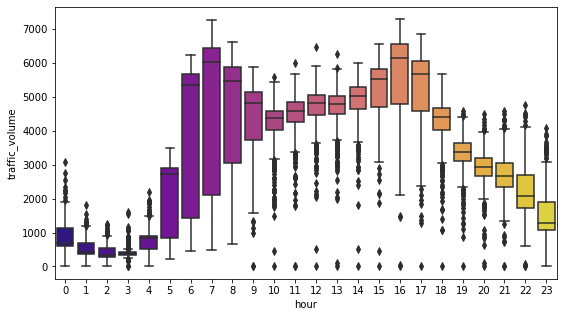

In [9]:
### PLOT TRAFFIC DISTRIBUTION IN EACH HOUR ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.hour, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('hour')

As clearly visible and intuitable, the data show different levels of seasonality. Starting from the monthly aggregation, we can see a reduction in traffic level when people tend to go on holiday (Christmas/summer period). Weekly and hourly patterns are the results of human behaviors from the normal usage of the public transport system. Other analysis showed that in the presence of extreme events (such as snowstorms) the traffic can drastically change. This information is present as an additional categorical source.

## THE MODEL


Our workflow is depicted as follows. Given a selected time interval of meaningful data, we force the introduction of some missing intervals (with a fixed length and proportion) in the data stream. The missing sequences form the main input for our Variational AutoEncoder that is trained to approximate the true sequences without missing pieces. Important to notice that we start from a complete data source, on which we insert random missing intervals because this enables us to make a comparison with the true reality and compute performance metrics.


The second meaningful inputs of the VAE are sequences of integers that encode the additional information present as categorical features, i.e. month, weekday, hour, holiday, weather conditions. In correspondence with missing values in the raw traffic signals, we take care to substitute the corresponding categories with a special integer (let’s say 0) to encode properly the status of ‘missing information’ (this is not valid for the month, weekday, hour which are known always for every date).


The encoder consists of an LSTM cell. It receives as input 3D sequences resulting from the concatenation of the raw traffic data and the embeddings of categorical features. As in every encoder in a VAE architecture, it produces a 2D output that is used to approximate the mean and the variance of the latent distribution. The decoder samples from the 2D latent distribution upsampling to form 3D sequences. The generated sequences are then concatenated back with the original categorical embeddings which are passed through an LSTM cell to reconstruct the original traffic sequences.

The training of a VAE is made minimizing a loss which is the combination of two pieces. A reconstruction part (scaled mean squared error in our case), that says how much the model can reproduce the target, and a regularization part (Kullback Leibler divergence), which acts as a constraint to make the latent space more similar to a normal distribution.

In [10]:
### NUMERICAL ENCODE CATEGORICAL COLUMNS ###

map_col = dict()

X = df.select_dtypes(include=['object']).copy()
for i,cat in enumerate(X):
    X[cat] = df[cat].factorize()[0]
    map_col[cat] = i

X['month'] = df.index.month;  i += 1;  map_col['month'] = i
X['weekday'] = df.index.weekday;  i += 1;  map_col['weekday'] = i
X['hour'] = df.index.hour;  i += 1;  map_col['hour'] = i
X.shape

(24096, 6)

In [13]:
### UTILITY FUNCTION FOR 3D SEQUENCE GENERATION ###

def gen_seq(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [14]:
### GENERATE 3D SEQUENCES ###

sequence_length = 24*7

sequence_input = []
sequence_target = []

for seq in gen_seq(X, sequence_length, X.columns):
    sequence_input.append(seq)
    
for seq in gen_seq(df, sequence_length, ['traffic_volume']):
    sequence_target.append(seq)
    
sequence_input = np.asarray(sequence_input)
sequence_target = np.asarray(sequence_target)

sequence_input.shape, sequence_target.shape

((23928, 168, 6), (23928, 168, 1))

In [15]:
### UTILITY FUNCTION TO INSERT RANDOM MISSING INTERVALS ###

def drop_fill_pieces(sequence_input, sequence_target, missing_len, missing_val=np.nan, size=0.2):
    
    sequence_input = np.copy(sequence_input)
    sequence_target = np.copy(sequence_target)
    
    _id_seq = np.random.choice(range(len(sequence_target)), int(len(sequence_target)*size), replace=False)
    _id_time = np.random.randint(0,sequence_length-missing_len, int(len(sequence_target)*size))
    
    for i,t in zip(_id_seq, _id_time):
        sequence_input[i, t:t+missing_len, 
                       [map_col['holiday'], 
                        map_col['weather_main'],
                        map_col['weather_description']]] = -1
        sequence_target[i, t:t+missing_len, :] = missing_val
        
    sequence_input[:,:, 
                   [map_col['holiday'], 
                    map_col['weather_main'],
                    map_col['weather_description']]] += 1
    
    return sequence_input, sequence_target

In [16]:
### INSERT MISSING INTERVALS AT RANDOM ###

np.random.seed(33)

missing_len = 24
sequence_input, sequence_target_drop = drop_fill_pieces(sequence_input, sequence_target,
                                                        missing_len=missing_len, size=0.6)

sequence_input.shape, sequence_target_drop.shape

((23928, 168, 6), (23928, 168, 1))

In [17]:
### TRAIN TEST SPLIT ###

train_size = 0.8

sequence_input_train = sequence_input[:int(len(sequence_input)*train_size)]
sequence_input_test = sequence_input[int(len(sequence_input)*train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)

sequence_target_train = sequence_target[:int(len(sequence_target)*train_size)]
sequence_target_test = sequence_target[int(len(sequence_target)*train_size):]
print(sequence_target_train.shape, sequence_target_test.shape)

sequence_target_drop_train = sequence_target_drop[:int(len(sequence_target_drop)*train_size)]
sequence_target_drop_test = sequence_target_drop[int(len(sequence_target_drop)*train_size):]
print(sequence_target_drop_train.shape, sequence_target_drop_test.shape)

(19142, 168, 6) (4786, 168, 6)
(19142, 168, 1) (4786, 168, 1)
(19142, 168, 1) (4786, 168, 1)


In [18]:
### UTILITY CLASS FOR SEQUENCES SCALING ###

class Scaler1D:
    
    def fit(self, X):
        self.mean = np.nanmean(np.asarray(X).ravel())
        self.std = np.nanstd(np.asarray(X).ravel())
        return self
        
    def transform(self, X):
        return (X - self.mean)/self.std
    
    def inverse_transform(self, X):
        return (X*self.std) + self.mean

In [19]:
### SCALE SEQUENCES AND MASK NANs ###

scaler_target = Scaler1D().fit(sequence_target_train)

sequence_target_train = scaler_target.transform(sequence_target_train)
sequence_target_test = scaler_target.transform(sequence_target_test)

sequence_target_drop_train = scaler_target.transform(sequence_target_drop_train)
sequence_target_drop_test = scaler_target.transform(sequence_target_drop_test)

mask_value = -999.
sequence_target_drop_train[np.isnan(sequence_target_drop_train)] = mask_value
sequence_target_drop_test[np.isnan(sequence_target_drop_test)] = mask_value

In [20]:
### UTILITY FUNCTIONS FOR VAE CREATION ###

latent_dim = 2

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def sampling(args):
    
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_loss(inp, original, out, z_log_sigma, z_mean):
    
    reconstruction = K.mean(K.square(original - out)) * sequence_length
    kl = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))

    return reconstruction + kl

def get_model():
    
    set_seed(33)
    
    ### encoder ###
    
    inp = Input(shape=(sequence_length, 1))
    inp_original = Input(shape=(sequence_length, 1))
    
    cat_inp = []
    cat_emb = []
    for cat,i in map_col.items():
        inp_c = Input(shape=(sequence_length,))
        if cat in ['holiday', 'weather_main', 'weather_description']:
            emb = Embedding(X[cat].max()+2, 6)(inp_c)
        else:
            emb = Embedding(X[cat].max()+1, 6)(inp_c)
        cat_inp.append(inp_c)
        cat_emb.append(emb)
    
    concat = Concatenate()(cat_emb + [inp])
    enc = LSTM(64)(concat)
    
    z = Dense(32, activation="relu")(enc)
        
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
            
    encoder = Model(cat_inp + [inp], [z_mean, z_log_sigma])
    
    ### decoder ###
    
    inp_z = Input(shape=(latent_dim,))

    dec = RepeatVector(sequence_length)(inp_z)
    dec = Concatenate()([dec] + cat_emb)
    dec = LSTM(64, return_sequences=True)(dec)
    
    out = TimeDistributed(Dense(1))(dec)
    
    decoder = Model([inp_z] + cat_inp, out)   
    
    ### encoder + decoder ###
    
    z_mean, z_log_sigma = encoder(cat_inp + [inp])
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder([z] + cat_inp)
    
    vae = Model(cat_inp + [inp, inp_original], pred)
    vae.add_loss(vae_loss(inp, inp_original, pred, z_log_sigma, z_mean))
    vae.compile(loss=None, optimizer=Adam(lr=1e-3))
    
    return vae, encoder, decoder

In [21]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
vae, enc, dec = get_model()
vae.fit([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train, sequence_target_train], 
         batch_size=128, epochs=100, validation_split=0.2, shuffle=False, callbacks=[es])

C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
120/120 [==============================] - 13s 44ms/step - loss: 80.3597 - val_loss: 37.5229
Epoch 2/100
120/120 [==============================] - 4s 31ms/step - loss: 22.6670 - val_loss: 23.1471
Epoch 3/100
120/120 [==============================] - 4s 31ms/step - loss: 15.4417 - val_loss: 23.8761
Epoch 4/100
120/120 [==============================] - 4s 31ms/step - loss: 13.6259 - val_loss: 24.1616
Epoch 5/100
120/120 [==============================] - 4s 31ms/step - loss: 13.2093 - val_loss: 23.7273
Epoch 6/100
120/120 [==============================] - 4s 31ms/step - loss: 12.1793 - val_loss: 27.4260
Epoch 7/100
120/120 [==============================] - 4s 31ms/step - loss: 11.7456 - val_loss: 19.7943
Epoch 8/100
120/120 [==============================] - 4s 31ms/step - loss: 10.6240 - val_loss: 19.5083
Epoch 9/100
120/120 [==============================] - 4s 30ms/step - loss: 10.2676 - val_loss: 19.0849
Epoch 10/100
120/120 [==============================] - 4s 30ms

In [22]:
### COMPUTE RECONSTRUCTION ###

vae = Model(vae.input[:-1], vae.output)

reconstruc_train = scaler_target.inverse_transform(
    vae.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train]))
reconstruc_test = scaler_target.inverse_transform(
    vae.predict([sequence_input_test[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_test]))

reconstruc_train.shape, reconstruc_test.shape

((19142, 168, 1), (4786, 168, 1))

The main purpose of our approach is to develop an unsupervised framework that can fill the missing pieces that appear in the traffic volume stream. To test the goodness of this task we reserve part of our data to compute performance metrics, like the classical MSE/RMSE to verify the reconstruction ability. We can also compute specific statistics only on the missing pieces subject to reconstruction. The test set is obtained with a simple temporal split on the last part of the dataset. This part is roughly composed of the same proportion of missing sequences as in the whole dataset.

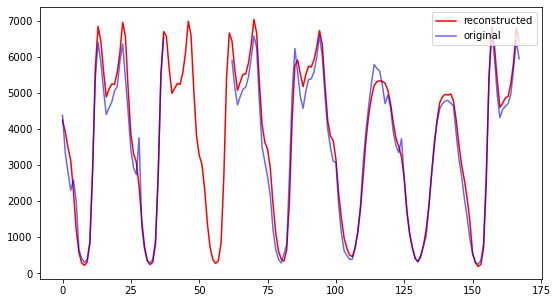

In [23]:
### PLOT REAL vs RECONSTRUCTION ###

id_seq = 100

seq = np.copy(sequence_target_drop_test[id_seq])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))
plt.plot(reconstruc_test[id_seq], label='reconstructed', c='red')
plt.plot(seq, c='blue', label='original', alpha=0.6)
plt.legend()

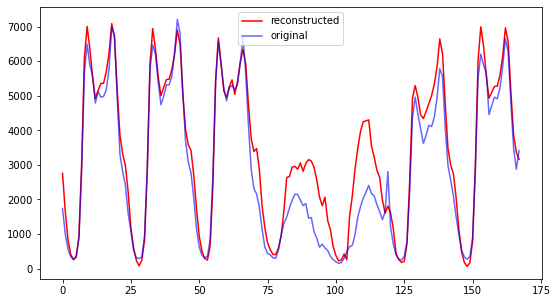

In [24]:
### PLOT REAL vs RECONSTRUCTION ###

id_seq = 800

seq = np.copy(sequence_target_drop_test[id_seq])
seq[seq == mask_value] = np.nan
seq = scaler_target.inverse_transform(seq)

plt.figure(figsize=(9,5))
plt.plot(reconstruc_test[id_seq], label='reconstructed', c='red')
plt.plot(seq, c='blue', label='original', alpha=0.6)
plt.legend()

In [25]:
### COMPUTE PERFORMANCES ON TRAIN ###

mask = (sequence_target_drop_train == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_train, -1), np.squeeze(sequence_target_train, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_train[mask].reshape(-1,missing_len), sequence_target_train[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 4053.44044967314
reconstruction error on missing sequences: 4056.9367671798354


In [26]:
### COMPUTE PERFORMANCES ON TEST ###

mask = (sequence_target_drop_test == mask_value)

print('reconstruction error on entire sequences:',
    mse(np.squeeze(reconstruc_test, -1), np.squeeze(sequence_target_test, -1), squared=False))
print('reconstruction error on missing sequences:',
    mse(reconstruc_test[mask].reshape(-1,missing_len), sequence_target_test[mask].reshape(-1,missing_len), squared=False))

reconstruction error on entire sequences: 4057.8968008974944
reconstruction error on missing sequences: 4066.0105272071137


In [27]:
### GET LATENT REPRESENTATION ON TRAIN DATA ###

enc_pred, _ = enc.predict([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train])
enc_pred.shape

(19142, 2)

A second possible application of our trained model consists of using it to generate new sequences. This is a common behavior of all the VAE where the encoder and the decoder can be utilized separately to create new samples. The encoder projects the inputs in a specific region of the latent space. We use the coordinates of the projections to sample new points nearby. The ‘vicinity’ can be regulated by selecting a desired amount of variance. The latent points are passed through the decoder to operate the sequence generations. Obviously, the closer are the points more similar are the final reconstructions. Important to notice also that the goodness of the sample generation is strictly related to the reconstruction ability of the entire VAE.


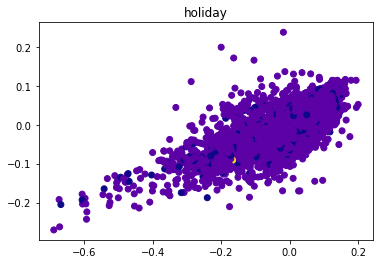

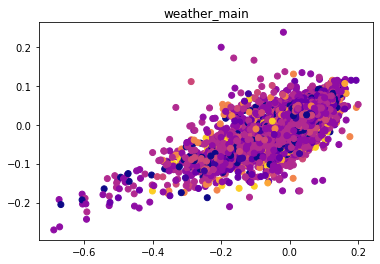

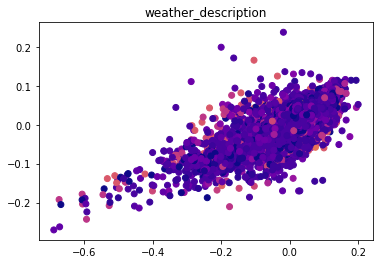

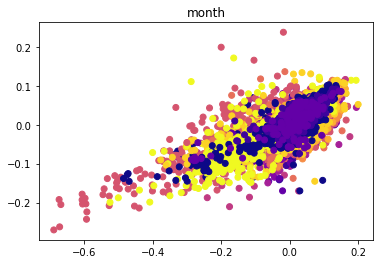

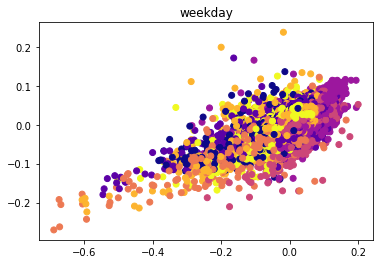

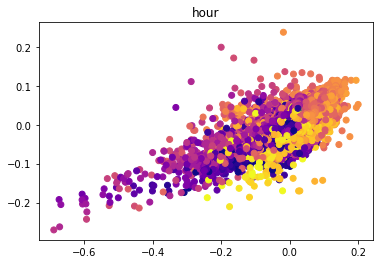

In [28]:
### PLOT LATENT REPRESENTATION ###

for cat,i in map_col.items():
    plt.scatter(enc_pred[:,0], enc_pred[:,1], c=sequence_input_train[:,sequence_length//2,i], cmap='plasma')
    plt.title(cat); plt.show()

In [29]:
### GENERATE RANDOM PERMUTATION ###

np.random.seed(33)

id_seq = 3333

_X = np.random.normal(enc_pred[id_seq,0], 3, 10)
_Y = np.random.normal(enc_pred[id_seq,1], 3, 10)
_cat_input = [sequence_input_train[[id_seq],:,i] for cat,i in map_col.items()]

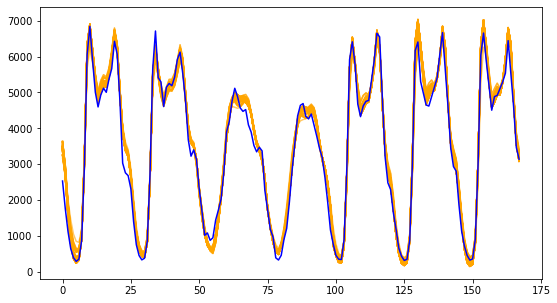

In [30]:
### PLOT RANDOM PERMUTATION ###

plt.figure(figsize=(9,5))
        
for x in _X:
    for y in _Y:
        dec_pred = dec.predict([np.asarray([[x,y]])] + _cat_input)
        plt.plot(scaler_target.inverse_transform(dec_pred[0]), c='orange', alpha=0.6)
plt.plot(scaler_target.inverse_transform(sequence_target_train[id_seq]), c='blue')